### Imports

In [2]:
% matplotlib inline

import sys
import os
os.chdir('../..')
sys.path.append('../..')
from pathlib import Path

import menpo.io as mio
import numpy as np
import tensorflow as tf
from menpo.visualize import print_progress

from project.utils import utils
from project.utils import tfrecords
from menpowidgets import visualize_images

In [1]:
dict1={1:[1,11,111],2:[2,22,222]}
dict2={3:[3,33,333],4:[4,44,444]}
dictMerged2=dict(dict1, **dict2)

In [2]:
from pathlib import Path
path = Path("./") 
??path.parent.mkdir
#path.parent.mkdir(parents=True)

# Generate TFRecords files

The recommended format for TensorFlow is a TFRecords file containing `tf.train.Example` protocol buffers (which contain `Features` as a field).

Here is a little program that gets your data, stuffs it in an `Example` protocol buffer, serializes the protocol buffer to a string, and then writes the string to a TFRecords file using the `tf.python_io.TFRecordWriter`.

In [14]:
def get_centre(lms):
    centre = lms.points[11]
    return centre

def get_head_scale(lms):
    scale = np.max(np.nanmax(lms.points, axis=0) - np.nanmin(lms.points, axis=0))
    return scale

In [12]:
def example_iterator(images):
    """ Given an iterable of images, returns a generator of example data """
    for idx, img in enumerate(print_progress(images, end_with_newline=False)):
        image_name = img.path.name

        lms = img.landmarks['PTS']
         
        img.landmarks['LMS'] = lms

        head_scale = get_head_scale(lms)

        rescale_factor = head_scale / 150
        centre = get_centre(lms)
        
        visible_pts = ~np.isnan(lms.points)[:, 0]
        marked_index = ~np.isnan(lms.points)[:, 0]

        yield image_name, img, visible_pts, marked_index, rescale_factor, centre, head_scale

def generate(iterator,
             store_path='./',
             record_name='train.tfrecords',
             store_records=True):
    store_path = Path(store_path)

    if store_records:
        writer = tf.python_io.TFRecordWriter(str(store_path / record_name))

    for img_name, pimg, visible_pts, marked_index, rescale_factor, centre, head_scale in iterator:

        joints_lms = pimg.landmarks['LMS'].points

        # crop images and store necessary information                
        cimg, trans, c_scale = utils.crop_image(pimg, centre, rescale_factor, [384, 384])

        img_path = store_path / '{}'.format(img_name)

        if store_records:
            try:
                # construct the Example proto object
                example = tf.train.Example(
                    features=tf.train.Features(
                        # Features contains a map of string to Feature proto objects
                        feature={
                            # images
                            'image': tfrecords.jpg_feature(cimg),
                            'height': tfrecords.int_feature(cimg.shape[0]),
                            'width': tfrecords.int_feature(cimg.shape[1]),
                            # landmarks
                            'n_landmarks': tfrecords.int_feature(cimg.landmarks['LMS'].n_points),
                            'gt': tfrecords.bytes_feature(cimg.landmarks['LMS'].points.astype(np.float32).tobytes()),
                            'scale': tfrecords.float_feature(head_scale / c_scale),
                            'visible': tfrecords.bytes_feature(visible_pts.astype(np.int64).tobytes()),
                            'marked': tfrecords.bytes_feature(marked_index.astype(np.int64).tobytes()),
                            # original image information
                            'original_scale': tfrecords.float_feature(rescale_factor),
                            'original_centre': tfrecords.bytes_feature(centre.astype(np.float32).tobytes()),
                            'original_lms': tfrecords.bytes_feature(joints_lms.astype(np.float32).tobytes()),
                            # inverse transform to original landmarks
                            'restore_translation': tfrecords.bytes_feature(
                                trans.h_matrix.astype(np.float32).tobytes()),
                            'restore_scale': tfrecords.float_feature(c_scale),
                        }))
                # use the proto object to serialize the example to a string
                serialized = example.SerializeToString()
                # write the serialized object to disk
                writer.write(serialized)
                
                

            except Exception as e:
                print('Something bad happened when processing image: "{}"'.format(img_name))
                print(e)

    if store_records:
        writer.close()

## Generate Train/Validation/Test TFRecords files

Run the following cells to split the images into training, validation and test sets, and then generate TFRecords files for each.

In [7]:
# Where are the images located?
images_folder = Path('/media/taopan/data/datasets/ptstwo-all/img')

# Where are the landmark annotation files located?
ljson_folder = Path('/media/taopan/data/datasets/ptstwo-all/img')

# What's the landmark template called?
template = 'LV'

# How do we find the ljson file for a given image?
def resolver(image_file):
    ljson_folder = image_file.parent
    ljson_file = ljson_folder.joinpath(image_file.stem + '.pts')
    return {'PTS' : ljson_file}

# where should the resulting TFRecords files be written to?
store_path = Path('/media/taopan/data/landmark/project-master/data/tfrecords/lv')
train_record_name = "train50.tfrecords"
eval_record_name  = "eval20.tfrecords"
test_record_name  = "test20.tfrecords"

# What proportion of the data should be held out for testing?
test_size = 0.25

# What proportion of the data should be used for validation?
eval_size = 0.25
eval_size = eval_size / (1 - test_size)

In [15]:
from sklearn.model_selection import train_test_split

# Run this to generate the TFRecord files!

# load the images
images = mio.import_images(images_folder, landmark_resolver=resolver)

# divide the images into training/test sets
indices = range(len(images))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)

# divide the training set further into training/validation sets
indices_train, indices_eval = train_test_split(indices_train, test_size=eval_size, random_state=42)

images_train = images[indices_train]
images_eval = images[indices_eval]
images_test = images[indices_test]

print('Found {} assets in total, to be split like so:'.format(len(images)))
print('- Training set size:   {}'.format(len(images_train)))
print('- Validation set size: {}'.format(len(images_eval)))
print('- Test set size:       {}'.format(len(images_test)))

# generate training TFRecords
generate(example_iterator(images_train), store_path, train_record_name,
         store_records=True)

# generate validation TFRecords
generate(example_iterator(images_eval), store_path, eval_record_name,
         store_records=True)

# generate test TFRecords
generate(example_iterator(images_test), store_path, test_record_name,
         store_records=True)

Found 96 assets in total, to be split like so:
- Training set size:   48
- Validation set size: 24
- Test set size:       24
[====================] 100% (24/24) - done.                                     

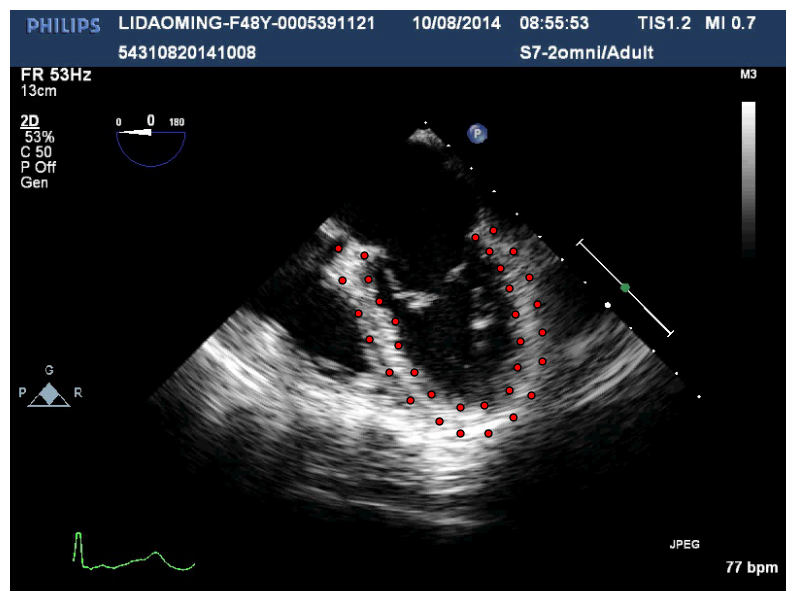

In [6]:
visualize_images(images_train)

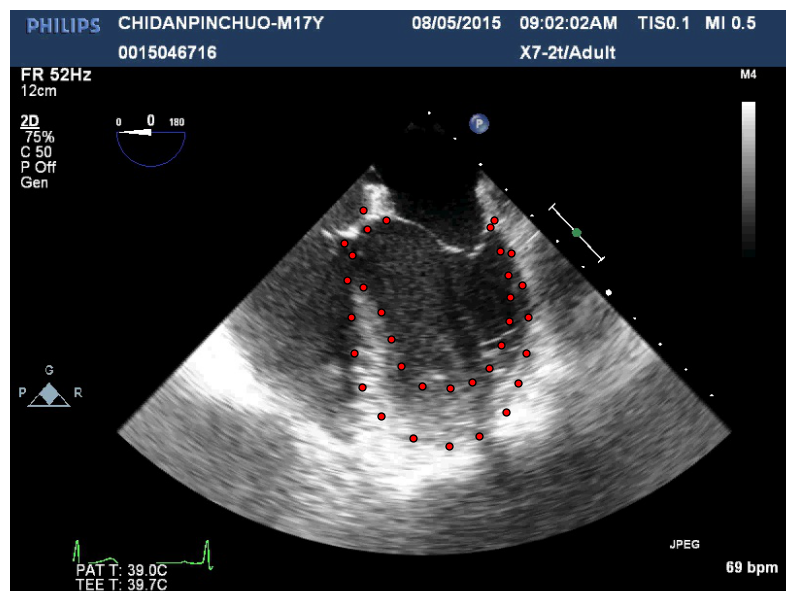

In [13]:
visualize_images(images_eval)

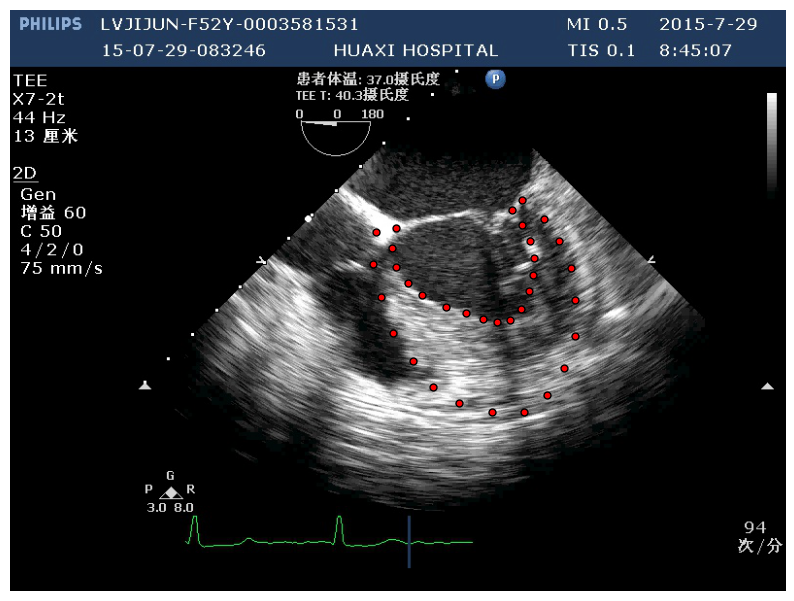

In [9]:
visualize_images(images_test)

#### Write something so you can see which images are in which dataset

In [16]:
import json

train_paths = [str(image.path) for image in images_train]
eval_paths = [str(image.path) for image in images_eval]
test_paths = [str(image.path) for image in images_test]

dic = {
    'train': {
        'count': len(train_paths),
        'record_name': train_record_name,
        'paths': train_paths
    },
    'validation': {
        'count': len(eval_paths),
        'record_name': eval_record_name,
        'paths': eval_paths
    },
    'test': {
        'count': len(test_paths),
        'record_name': test_record_name,
        'paths': test_paths,
    }
}

class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Path):
            return str(obj)
        else:
            return super(MyEncoder, self).default(obj)

def write_json(filename, dictionary):
    print('Writing data manifest to {}'.format(filename))
    with open(filename, 'w') as handle:
      json.dump(dictionary, handle, indent=4)

if dic:
    filename = store_path / 'LV_data_manifest'
    write_json('{}.json'.format(filename), dic)

Writing data manifest to I:\menpo-dl\project-master\data\tfrecords\lv\LV_data_manifest.json
